# Prediction Modeling – Using Topics and Contextual Data

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

### Load Text Data

In [2]:
df_text = pd.read_pickle(os.path.join('data_files', 'lt_processed.pkl'))

In [3]:
df_text.shape

(14786, 3)

In [4]:
df_text.head(2)

,bill_id,long_title,bill_status
0,17SBN-2235,"[fiscal, regime, mining, industry]",Pending
1,17SBN-2234,"[sale, certain, land, barangay, na, ligas, cit...",Passed


Drop Pending Senate Bills

In [5]:
df_text.bill_status.value_counts()

Pending     14270
Passed        427
Archived       89
Name: bill_status, dtype: int64

In [6]:
df_text.drop(df_text[df_text.bill_status == 'Pending'].index,
             inplace=True)

Set Target Variable 'Pass'

In [7]:
df_text['Pass'] = np.where(df_text.bill_status == 'Passed', True, False)

In [8]:
df_text.drop(['bill_status'], axis=1, inplace=True)

In [9]:
df_text.shape

(516, 3)

In [10]:
df_text.head()

,bill_id,long_title,Pass
1,17SBN-2234,"[sale, certain, land, barangay, na, ligas, cit...",True
2,17SBN-2233,"[excise, tax, tobacco, subject, tax, increment...",True
7,17SBN-2228,"[nature, park, barangay, city, province, bataa...",True
40,17SBN-2195,"[court, community, service, lieu, imprisonment...",True
47,17SBN-2188,"[bed, capacity, memorial, hospital, medical, c...",True


### Load Context Data

In [11]:
df_context = pd.read_pickle(os.path.join('data_files', 'encoded.pkl'))

In [12]:
df_context.drop('Pass', axis=1, inplace=True)
df_context.shape

(529, 31)

### Merged Data: Text + Context

In [13]:
df = pd.merge(df_text, df_context, how='left', on='bill_id')

In [14]:
df.shape

(516, 33)

In [15]:
df.head(2)

,bill_id,long_title,Pass,Years of Service,num_authors,delta_days,scope_national,majority_bloc,len_desc,Party_Bagumbayan-VNP,...,month_December,month_February,month_January,month_July,month_June,month_March,month_May,month_November,month_October,month_September
0,17SBN-2234,"[sale, certain, land, barangay, na, ligas, cit...",True,18,3,34,True,True,300,0,...,0,0,0,0,0,0,1,0,0,0
1,17SBN-2233,"[excise, tax, tobacco, subject, tax, increment...",True,3,6,34,True,True,426,0,...,0,0,0,0,0,0,1,0,0,0


### Load Topic Modeling Results

In [16]:
topic_dict = pickle.load(open(os.path.join('data_files',
                                           'topic_dict.pkl'), 'rb'))

In [17]:
def topic_mapper(lst1, lst2):
    intersect_list = list(set(lst1) & set(lst2))
    return 1 if len(intersect_list) > 0 else 0

In [18]:
df['t_0'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[0]))
df['t_1'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[1]))
df['t_2'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[2]))
df['t_3'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[3]))
df['t_4'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[4]))
df['t_5'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[5]))
df['t_6'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[6]))
df['t_7'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[7]))
df['t_8'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[8]))
df['t_9'] = df.long_title.map(lambda x: topic_mapper(x, topic_dict[9]))

In [19]:
print(f" N-Topic 0 Obs: {df.t_0.sum()}\n",
      f"N-Topic 1 Obs: {df.t_1.sum()}\n",
      f"N-Topic 2 Obs: {df.t_2.sum()}\n",
      f"N-Topic 3 Obs: {df.t_3.sum()}\n",
      f"N-Topic 4 Obs: {df.t_4.sum()}\n",
      f"N-Topic 5 Obs: {df.t_5.sum()}\n",
      f"N-Topic 6 Obs: {df.t_6.sum()}\n",
      f"N-Topic 7 Obs: {df.t_7.sum()}\n",
      f"N-Topic 8 Obs: {df.t_8.sum()}\n",
      f"N-Topic 9 Obs: {df.t_9.sum()}")

 N-Topic 0 Obs: 261
 N-Topic 1 Obs: 227
 N-Topic 2 Obs: 77
 N-Topic 3 Obs: 221
 N-Topic 4 Obs: 259
 N-Topic 5 Obs: 59
 N-Topic 6 Obs: 256
 N-Topic 7 Obs: 226
 N-Topic 8 Obs: 37
 N-Topic 9 Obs: 249


### Combined Data: Merged Data + Topic

In [20]:
df.drop(['bill_id', 'long_title'], axis=1, inplace=True)

In [21]:
df.head()

,Pass,Years of Service,num_authors,delta_days,scope_national,majority_bloc,len_desc,Party_Bagumbayan-VNP,Party_Independent,Party_LDP,...,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9
0,True,18,3,34,True,True,300,0,0,0,...,1,0,0,0,1,1,0,0,1,0
1,True,3,6,34,True,True,426,0,0,0,...,1,1,1,1,1,0,1,1,0,1
2,True,6,3,40,True,True,201,0,0,0,...,1,1,0,1,1,0,1,1,0,1
3,True,12,4,151,True,False,258,0,0,0,...,0,1,1,0,0,0,0,0,0,0
4,True,9,2,73,False,True,354,0,0,0,...,1,1,1,1,1,0,1,1,0,1


In [22]:
df.dtypes

Pass                      bool
Years of Service         int64
num_authors              int64
delta_days               int64
scope_national            bool
majority_bloc             bool
len_desc                 int64
Party_Bagumbayan-VNP     uint8
Party_Independent        uint8
Party_LDP                uint8
Party_Lakas              uint8
Party_Lakas-CMD          uint8
Party_Lakas-Kampi-CMD    uint8
Party_Liberal            uint8
Party_NPC                uint8
Party_Nacionalista       uint8
Party_PDP_Laban          uint8
Party_PMP                uint8
Party_PRP                uint8
Party_UNA                uint8
month_August             uint8
month_December           uint8
month_February           uint8
month_January            uint8
month_July               uint8
month_June               uint8
month_March              uint8
month_May                uint8
month_November           uint8
month_October            uint8
month_September          uint8
t_0                      int64
t_1     

### Correlation Matrix

In [23]:
cols_to_move = ['Pass']
cols = [col for col in df if col not in cols_to_move] + cols_to_move
df = df[cols]

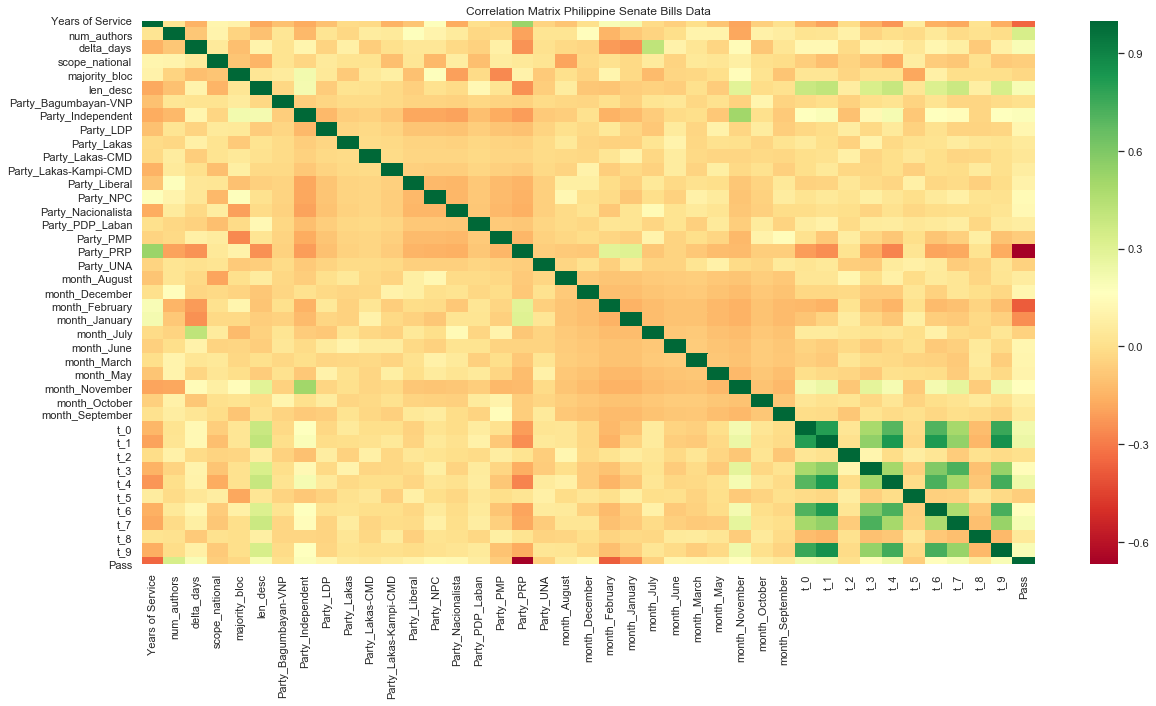

In [24]:
sns.set()
cor = df.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(cor, annot=False, cmap="RdYlGn")
plt.title('Correlation Matrix Philippine Senate Bills Data')
plt.show()

In [25]:
cor.Pass

Years of Service        -0.353325
num_authors              0.338666
delta_days               0.194373
scope_national          -0.058840
majority_bloc           -0.024889
len_desc                 0.198616
Party_Bagumbayan-VNP     0.009195
Party_Independent        0.181348
Party_LDP                0.119334
Party_Lakas              0.053539
Party_Lakas-CMD          0.040353
Party_Lakas-Kampi-CMD    0.070446
Party_Liberal            0.099561
Party_NPC                0.133601
Party_Nacionalista       0.128765
Party_PDP_Laban          0.073753
Party_PMP               -0.065198
Party_PRP               -0.668373
Party_UNA               -0.047451
month_August             0.064070
month_December           0.115163
month_February          -0.378081
month_January           -0.250947
month_July              -0.047946
month_June               0.119334
month_March              0.113429
month_May                0.103773
month_November           0.164299
month_October            0.074853
month_Septembe

### Feature Selection

In [26]:
colsOfInterest = list(cor[(cor.Pass > 0.3) |
                          (cor.Pass < -0.3)]['Pass'].index)
print(len(colsOfInterest))
colsOfInterest

5


['Years of Service', 'num_authors', 'Party_PRP', 'month_February', 'Pass']

Oddly, our topic fields created from our Topic Modeling does not show strong correlation to our target variable.
<br>
Hence, the result of our modeling is the same with the Step 4.

In [27]:
df = df[colsOfInterest]
df.head(3)

,Years of Service,num_authors,Party_PRP,month_February,Pass
0,18,3,0,0,True
1,3,6,0,0,True
2,6,3,0,0,True


### Train-Test Split

##### Xy Variable Selection

In [28]:
X = df.drop(['Pass'], axis=1)
print(X.shape)

(516, 4)


In [29]:
y = df['Pass']
y.shape

(516,)

##### Standardization

In [30]:
scaler = StandardScaler()

In [31]:
X = scaler.fit_transform(X)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=43)

In [33]:
print(f"Our new train set has {X_train.shape[0]} data points;",
      f"{np.sum(y_train)} of which are actual positives.")

Our new train set has 387 data points; 330 of which are actual positives.


### SVC

In [34]:
svc = SVC(gamma='auto', kernel='linear', random_state=42)

In [35]:
svc.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [36]:
predicted = svc.predict(X_test)

In [37]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       1.00      0.72      0.84        32
        True       0.92      1.00      0.96        97

    accuracy                           0.93       129
   macro avg       0.96      0.86      0.90       129
weighted avg       0.94      0.93      0.93       129



### Random Forest

In [38]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15,
                                  random_state=42)

In [39]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
predicted = rf_model.predict(X_test)

In [41]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

       False       1.00      0.81      0.90        32
        True       0.94      1.00      0.97        97

    accuracy                           0.95       129
   macro avg       0.97      0.91      0.93       129
weighted avg       0.96      0.95      0.95       129



### k-Fold Cross Validation

##### Using K-Neighbors Classifier

In [42]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[0.90384615 0.88461538 0.96153846 0.96153846 0.98076923 1.
 1.         0.94117647 0.88235294 0.88235294]


In [43]:
print(scores.mean())

0.9398190045248869


In [44]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.928054298642534, 0.9223981900452489, 0.9398567119155354, 0.9303544494720966, 0.9398190045248869, 0.9437782805429864, 0.9358974358974359, 0.9340497737556561, 0.9340497737556561, 0.9282805429864254, 0.9203242835595777, 0.9067496229260936, 0.9164027149321268, 0.9067119155354451, 0.9144042232277527, 0.9144042232277527, 0.9201734539969835, 0.918212669683258, 0.9220588235294118, 0.9181372549019609, 0.9200603318250377, 0.9200603318250377, 0.9200603318250377, 0.9180995475113122, 0.9180995475113122, 0.9142533936651585, 0.9142533936651585, 0.912292609351433, 0.912292609351433, 0.912292609351433]


Text(0, 0.5, 'Cross-Validated Accuracy')

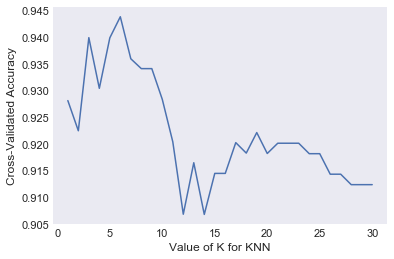

In [45]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.style.use('seaborn-dark')

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

##### Using Logistic Regression

In [46]:
# Best k for knn is 8. How about Logistic Regression?
# 10-fold cross-validation with logistic regression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.9260180995475114


##### Using Decision Tree Classifier

In [47]:
tree_model = DecisionTreeClassifier(random_state=42)
print(cross_val_score(tree_model, X, y, cv=10, scoring='accuracy').mean())

0.9437405731523378


##### Using Random Forest Classifier

In [48]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15,
                                  random_state=42)
print(cross_val_score(rf_model, X, y, cv=10, scoring='accuracy').mean())

0.9417797888386124


In [49]:
# search for an optimal value of K for KNN
n_range = list(range(5, 15))
rf_scores = []
for n in n_range:
    rf_model = RandomForestClassifier(n_estimators=200, max_depth=n,
                                      random_state=42)
    scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
    rf_scores.append(scores.mean())
print(rf_scores)

[0.9396304675716441, 0.9377828054298643, 0.9417043740573152, 0.9378582202111614, 0.9378582202111614, 0.9378582202111614, 0.9378582202111614, 0.9378582202111614, 0.9378582202111614, 0.9378582202111614]


Text(0, 0.5, 'Cross-Validated Accuracy')

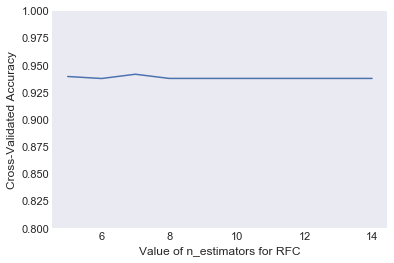

In [50]:
# plot the value of K for rf (x-axis) vs the cross-validated accuracy (y-axis)
plt.style.use('seaborn-dark')

plt.plot(n_range, rf_scores)
plt.ylim(0.8, 1)
plt.xlabel('Value of n_estimators for RFC')
plt.ylabel('Cross-Validated Accuracy')